#Logistic Regression

Despite its name, [logistic (logit) regression](http://en.wikipedia.org/wiki/Logistic_regression) is actually a classification algorithm, not a regression model. The "regression" part comes from the fact that it attempts to fit a linear model to the feature space; it is thus a generalization of the linear regression model to classification problems.

The general goal of logistic regression is to learn to correctly classify binary classes, where $Y = \{0, 1\}$.

Recall that in a linear regression, we used a set of covariates to predict the value of a **continuous** outcome variable.

In a logistic regression, we will use a set of covariates **to predict the probabilities of binary class membership**. The probabilities are then mapped to class labels, thus solving the classification problem.

For example, if we determine that the probability of being either male or female for a record is 0.55, and anything over 0.50 is male, then we can state with some confidence that the record in question is male according to logistic regression.

Another key difference between a linear and logistic regression is that in a linear model, we assume that the outcome values can go from $(-\infty, +\infty)$. In a logistic regression, we need to map the outcome values to the unit interval $[0, 1]$. We do this by using a transformation call the **logistic function**:

$$f(x) = \frac{e^x}{e^x + 1} = \frac{1}{1 + e^{-x}}$$

The logistic function can also be transformed into a linear version called the **logit (log-odds) function**:

$$g(x) = ln(\frac{\pi(x)}{1-\pi(x)}) = \alpha + \beta x$$

To use the logistic function:
<ol>
<li>Model consists of a vector $\beta$ in d-dimensional feature space</li>
<li>For a point $x$, project it onto $\beta$ to convert it into a real number $z$ in the range $(-\infty, +\infty)$</li>

$$z = \alpha + \beta \bullet x = \alpha + \beta_1 x_1 + ... + \beta_d x_d$$

<li>Map $z$ to the range $[0,1]$ using the logistic function</li>

$$p = \frac{1}{1 + e^{-z}}$$
</ol>

The resulting prediction is presented as a **probability of class membership**.

When you train the data, you'll need to optimize $\beta$ so the model gives the best possible reproduction of training set labels.

A few things to note about $f(x) = \alpha + \beta x$:

<img src="logistic_function_graph.png">

<ul>
<li>$\alpha$ controls the location of the midpoint</li>
<li>$\beta$ controls the slope of the rise</li>
</ul>

<img src="logistic_function_graph_compare.png">

###Titanic: Revisited

Let's explore logistic regression by applying it to the Titanic dataset.

As always, let's start by importing the correct packages and the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv('titanic.csv')

In [2]:
data.Survived.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Without modeling the data, what is our prediction benchmark?

In [3]:
print data.Survived.mean()
print 1 - data.Survived.mean()

0.383838383838
0.616161616162


It looks like 2/3 of the passengers perished based on the above data. This simple model would reach around 62% predictive accuracy (Why?), which is higher than predicting at random (50%).

Let's set the target values to the <code>Survived</code> values in the dataset.

In [5]:
target = data.Survived.values

<code>sklearn</code> estimators all work with homogeneous numerical features descriptors passed as a <code>numpy</code> array, so passing a raw DataFrame won't work.

We'll begin by building a model that only uses numerical features as input, like <code>data.Fare</code>, <code>data.Pclass</code>, and <code>data.Age</code>.

In [6]:
numerical_features = data.get(['Fare', 'Pclass', 'Age'])
numerical_features.head()

Fare  Pclass  Age
0   7.2500       3   22
1  71.2833       1   38
2   7.9250       3   26
3  53.1000       1   35
4   8.0500       3   35

If we look at all the data, however, we'll see that some passenger records (~177) don't have age information.

In [7]:
numerical_features.count()

Fare      891
Pclass    891
Age       714
dtype: int64

We'll use the pandas <code>fillna</code> method to input the median age for those passengers:

In [9]:
median_features = numerical_features.dropna().median()
median_features

Fare      15.7417
Pclass     2.0000
Age       28.0000
dtype: float64

In [10]:
imputed_features = numerical_features.fillna(median_features)
imputed_features.count()

Fare      891
Pclass    891
Age       891
dtype: int64

In [11]:
imputed_features.head()

Fare  Pclass  Age
0   7.2500       3   22
1  71.2833       1   38
2   7.9250       3   26
3  53.1000       1   35
4   8.0500       3   35

The DataFrame is now clean and can be converted into a homogeneous <code>numpy</code> array of floating point values:

In [12]:
features_array = imputed_features.values
features_array

array([[  7.25  ,   3.    ,  22.    ],
       [ 71.2833,   1.    ,  38.    ],
       [  7.925 ,   3.    ,  26.    ],
       ..., 
       [ 23.45  ,   3.    ,  28.    ],
       [ 30.    ,   1.    ,  26.    ],
       [  7.75  ,   3.    ,  32.    ]])

We'll take 80% of the data to train the first model and keep the remaining 20% for computing the generalization score:

In [13]:
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)

In [14]:
features_train.shape

(712, 3)

In [15]:
features_test.shape

(179, 3)

In [16]:
target_train.shape

(712,)

In [17]:
target_test.shape

(179,)

We'll now initialize a <code>LogisticRegression</code> instance from scikit-learn:

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

Let's use the <code>predict</code> function and pass through the <code>features_test</code> data.

In [19]:
target_predicted = lr.predict(features_test)

Now we can pass in the <code>target_test</code> and <code>target_predicted</code> data into the <code>accuracy_score</code> function to get the model's accuracy.

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(target_test, target_predicted)

0.73184357541899436

This instance of the model is ~73% accurate, which is better than our previous baseline.

###Model Evaluation and Interpretation

The <code>coef_</code> attribute of a fitted linear model like <code>LogisticRegression</code> holds the weights ($\beta_1, \beta_2, ..., \beta_n$) of each feature:

In [21]:
feature_names = numerical_features.columns.values
feature_names

array(['Fare', 'Pclass', 'Age'], dtype=object)

In [22]:
lr.coef_

array([[ 0.0043996 , -0.80916725, -0.03348064]])

Let's create a simple plot to help illustrate the relationship between each feature and the possible outcomes:

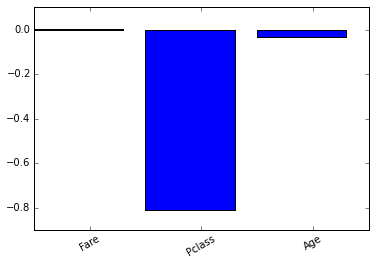

In [23]:
x = np.arange(len(feature_names))
plt.bar(x, lr.coef_.ravel()) # What does .ravel() do?
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

Based on the graph above, it looks like <code>Fare</code> is slightly positively correlated with survival (i.e., the higher the fare, the higher the likelihood of survival, according to the model), while lower class and older passengers are more likely to die (negative correlation between <code>Pclass</code> and survival and <code>Age</code> and survival), which makes sense based on historical accounts of the disaster.

####Predicting Probabilities of Outcomes

Since logistic regression is a probabilistic model, it does more than just predict a binary outcome (in this case, survived or not) given the input features; it can also estimate the posterior probability of the outcome given the input features (remember **Naïve Bayes**?) using the <code>predict_proba</code> method:

In [24]:
target_predicted_proba = lr.predict_proba(features_test)
target_predicted_proba[:5]

array([[ 0.75263264,  0.24736736],
       [ 0.75824771,  0.24175229],
       [ 0.58542437,  0.41457563],
       [ 0.25224882,  0.74775118],
       [ 0.75817844,  0.24182156]])

The decision threshold is 0.5 by default, but we can vary that value from 0 to 1 in order to change the model to address trade-offs between false positive and false negative prediction errors.

Let's build a confusion matrix to track the false positives and false negatives that occurred in this version of the model:

In [25]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(target_test, target_predicted))

[[98 12]
 [36 33]]


In this case, it looks like the model incorrectly classified 12 deceased passengers as survivors, and 36 surviving passengers as deceased.

Another way to check the quality of a binary classifier on imbalanced (?) data is to compute the <code>precision</code>, <code>recall</code> and <code>f1-score</code> of a model (at the default decision threshold of 0.5).

In [26]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted,
                            target_names=['not_survived', 'survived']))

              precision    recall  f1-score   support

not_survived       0.73      0.89      0.80       110
    survived       0.73      0.48      0.58        69

 avg / total       0.73      0.73      0.72       179



###Further Questions
<ol>
<li>What does "imbalanced data" mean?</li>
<li>What do <code>recall</code> and <code>f1-score</code> represent?</li>
</ol>